In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv002.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [83]:
%autoreload

cohort = mre_pinn.data.PatientCohort(patient_ids='0006', xarray_dir='../data/NAFLD')
#cohort = mre_pinn.data.PatientCohort.from_file('../data/NAFLD/NAFLD_2022-10-31_head10.xarrays', xarray_dir='../data/NAFLD')
#cohort.create_xarrays()
#cohort.save_xarrays()
#cohort.metadata
cohort.load_xarrays()
cohort.eval_baseline()

  0%|          | 0/1 [00:00<?, ?it/s]Loading ../data/NAFLD/0006/t1_pre_in.nc
Loading ../data/NAFLD/0006/t1_pre_water.nc
Loading ../data/NAFLD/0006/t1_pre_out.nc
Loading ../data/NAFLD/0006/t1_pre_fat.nc
Loading ../data/NAFLD/0006/t2.nc
Loading ../data/NAFLD/0006/mre_raw.nc
Loading ../data/NAFLD/0006/wave.nc
Loading ../data/NAFLD/0006/mre.nc
Loading ../data/NAFLD/0006/mask.nc
  0%|          | 0/1 [00:00<?, ?it/s]

  return key in self.data

  return key in self.data



100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


In [84]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', detach=True)
pde

In [85]:
%autoreload

x = torch.rand(64, 64, 64, 3)
x.requires_grad = True
y = x**2

mre_pinn.pde.laplacian(y, x).shape

torch.Size([64, 64, 64, 3])

In [108]:
%autoreload

pino = mre_pinn.model.SpectralTransformer(
    n_spatial_dims=3,
    n_channels_in=4,
    n_channels_out=1,
    n_spatial_freqs=128,
    n_channels_model=32,
    n_conv_blocks=3,
    n_spectral_blocks=0,
    activ_fn='g',
    omega=15/300
)
pino

SpectralTransformer(
  (spectral_fwd): SpectralTransform(
    (a_linear): Linear(in_features=4, out_features=32, bias=True)
    (conv_block1): ConvBlock(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): AvgPool3d(kernel_size=2, stride=2, padding=0)
    )
    (conv_block2): ConvBlock(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): AvgPool3d(kernel_size=2, stride=2, padding=0)
    )
    (conv_block3): ConvBlock(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool): AvgPool3d(kernel_size=2, stride=2, padding=0)
    )
    (x_linear): Linear(in_features=3, out_features=128, bias=True)
  )
  (spectral_inv): SpectralInverse(
    (y_linear): Linear(in_features=3, out_features=128, bias=True)
    (u_linear): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [109]:
%autoreload

model = mre_pinn.training.PINOModel(cohort, pino, pde, patch_size=None, batch_size=1)
model.compile(
    optimizer='adam',
    lr=1e-3,
    loss_weights=[1e-8, 1e0],
    loss=mre_pinn.training.losses.msae_loss
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=10, interact=True)

Compiling model...
'compile' took 0.000222 s



Training model...

0         [5.56e-04, 5.56e+04]    [5.56e-04, 5.56e+04]    []  


<IPython.core.display.Javascript object>


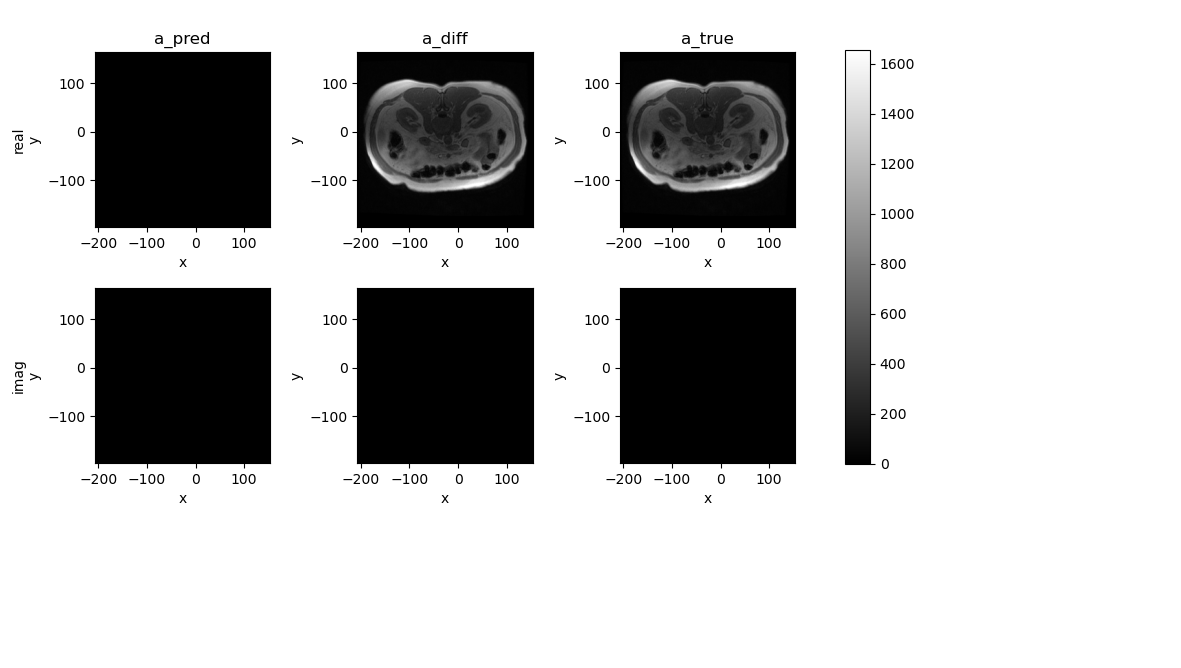

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


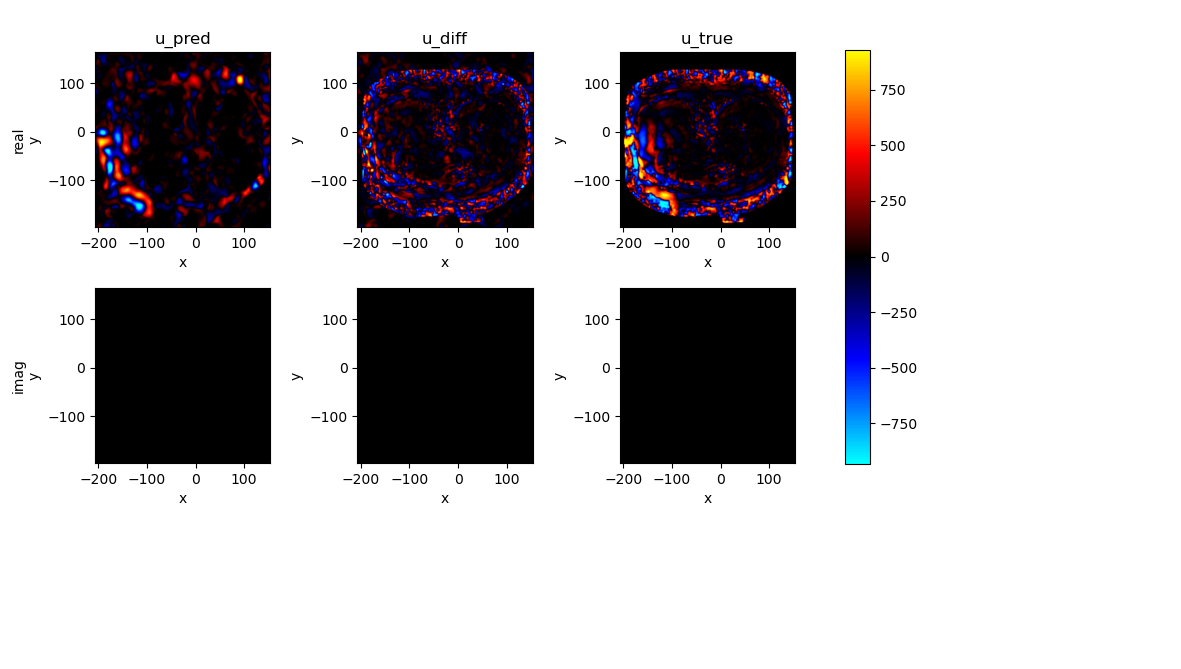

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


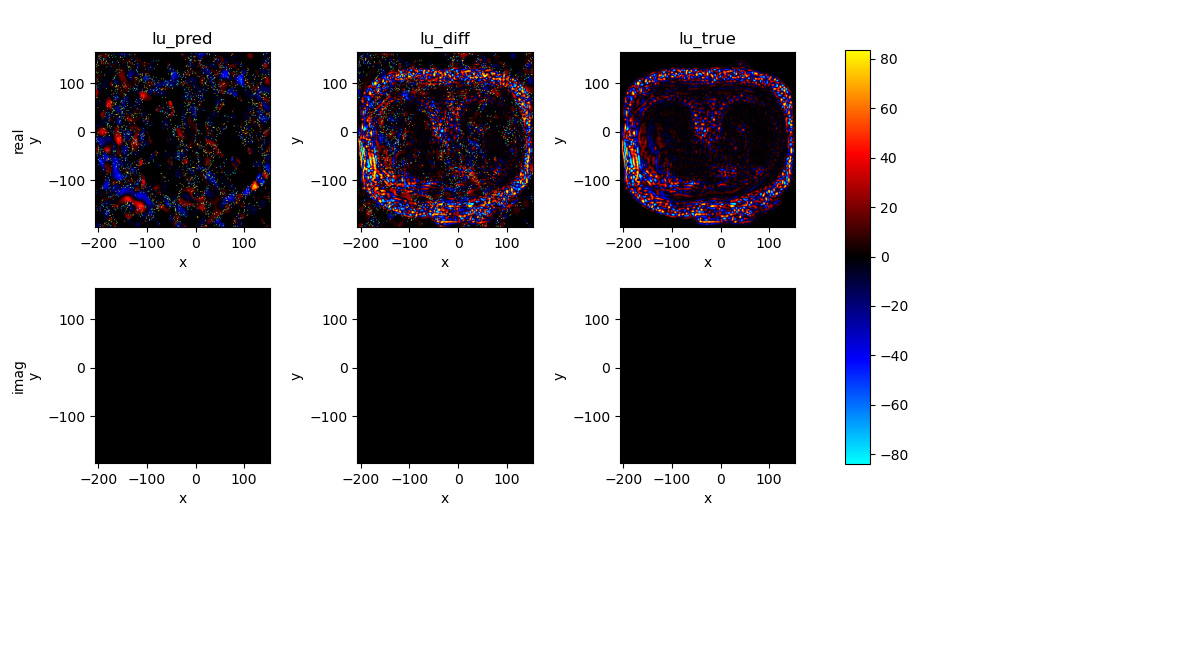

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

Time spent testing: 57.24%
10        [5.56e-04, 5.56e+04]    [5.56e-04, 5.56e+04]    []  
Time spent testing: 50.96%
20        [5.30e-04, 5.30e+04]    [5.30e-04, 5.30e+04]    []  
Time spent testing: 48.71%
30        [5.02e-04, 5.02e+04]    [5.02e-04, 5.02e+04]    []  
Time spent testing: 47.57%
40        [4.76e-04, 4.76e+04]    [4.76e-04, 4.76e+04]    []  
Time spent testing: 46.87%
50        [4.53e-04, 4.53e+04]    [4.53e-04, 4.53e+04]    []  
Time spent testing: 46.33%
60        [4.34e-04, 4.34e+04]    [4.34e-04, 4.34e+04]    []  
Time spent testing: 46.02%
70        [4.31e-04, 4.31e+04]    [4.31e-04, 4.31e+04]    []  
Time spent testing: 45.78%
80        [4.12e-04, 4.12e+04]    [4.12e-04, 4.12e+04]    []  
Time spent testing: 45.60%
90        [3.97e-04, 3.97e+04]    [3.97e-04, 3.97e+04]    []  
Time spent testing: 45.45%
100       [3.93e-04, 3.93e+04]    [3.93e-04, 3.93e+04]    []  
Time spent testing: 45.31%
110       [3.83e-04, 3.83e+04]    [3.83e-04, 3.83e+04]    []  
Time spent

In [ ]:
model.train(10000, display_every=10, callbacks=[test_eval])